In [73]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee

First I read the data that has been processed with IDL (Change that!). It contains a folded light curve with time in days and relative flux.

In [89]:
data = pd.read_csv('LCdata.csv')

timeLC = data['Time']
fluxLC = data['Flux']

oot = np.abs(24.0*timeLC) >= 1.1 #points outside of transit
errorLC = np.std(fluxLC[oot])

I define a few properties of the planet and the star, some of them will be fixed during the computations, some others not

In [90]:
## Planet properties
depth = 0.000174 #initial guess

period =  0.6892099 
ecc = 0.0
b = 0.5 

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Here I define a likelihood function that will help me find the best transit parameters and their uncertainties

In [91]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [92]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [93]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [94]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2676.789287
         Iterations: 600
         Function evaluations: 908


In [95]:
# Compute the light curve integrated over a Kepler long cadence
# exposure time.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

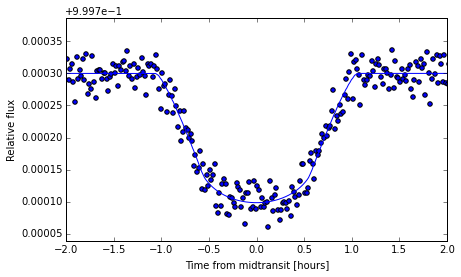

In [96]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

In [97]:
depth_ml, b_ml,  t0_ml, np.sqrt(sigma_ml**2+errorLC**2)

(0.00017218496279190212,
 0.49019824925452071,
 -2.1725803278368077e-05,
 1.8927484706438991e-05)

With the best fit solution, it is time to run and MCMC routine to estimate the uncertainties on the parameters

In [98]:
ndim, nwalkers = 8, 100
pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [99]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(timeLC, fluxLC, errorLC, allfixed));
sampler.run_mcmc(pos, 500);

In [100]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

Now I plot the results in a triangle plot 

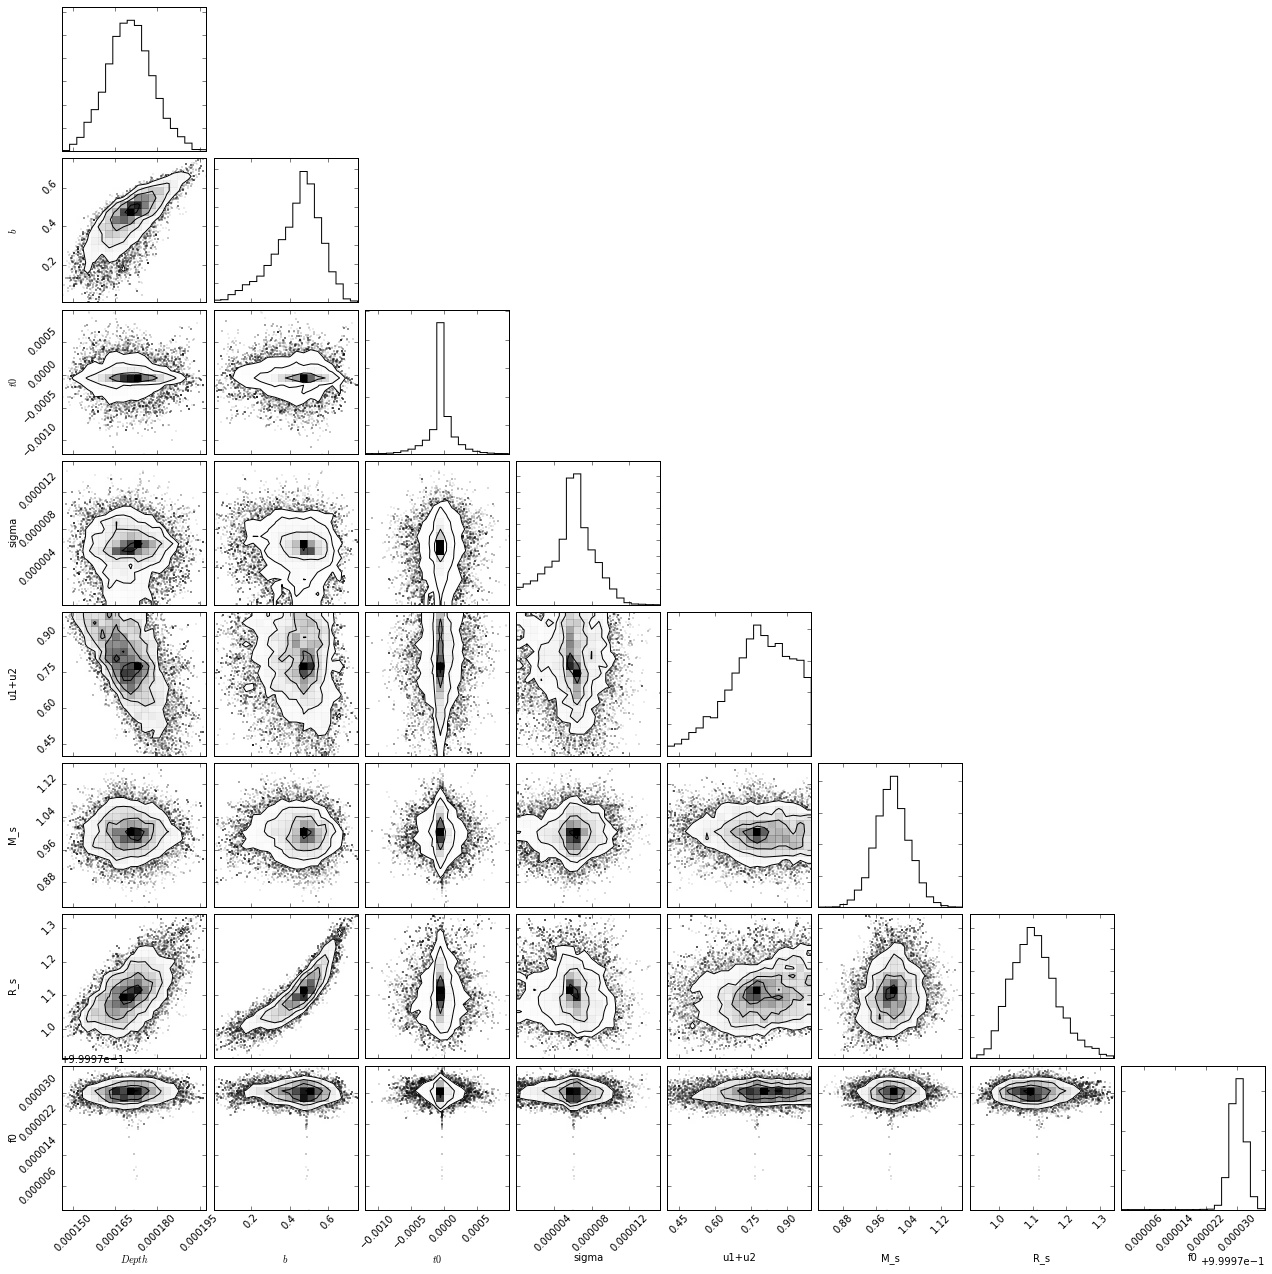

In [101]:
import corner
fig = corner.corner(samples, labels=["$Depth$", "$b$", "$t0$", "sigma", "u1+u2", "M_s", "R_s", "f0"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

And here I specifically compute the 50% percentile and the +- 1 sigma error interval of the parameters and some derived quantities

In [102]:
samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius is:

In [103]:
planetrad_mcmc

(1.5666381789700508, 0.12596031240014693, 0.11707311043953239)

The inverse of the scaled semi-major axis is:

In [19]:
r_a_mcmc

(0.32479621970019618, 0.026223189829603921, 0.017213108006102207)

In [20]:
 np.savetxt('finalparameters.txt', (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc,
                                    radius_mcmc, f0_mcmc, planetrad_mcmc,r_a_mcmc), fmt='%.4e', delimiter='   ',
            header = """Parameters obtained from a fit to the Kepler data. The first column represents the 50% percentile
            of the MCMC posterior distribution, whereas the second (third) represents the +1 (-1) sigma uncertainty. In row 
            order, the parameters are: Depth, Impact parameter, time of transit, Flux uncertainty, Sum of LD coefficients, 
            Mass of the star, Radius of the star (gaussian priors on both), out of eclipse flux, Planet radius, R_s/a.""") 